# Linear Regression

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as smf
import math
from statistics import variance
import numpy as np
import matplotlib.pyplot as plt

## Start the Data Wrangling

### Read in data

In [2]:
waterData = pd.read_csv('RRCA_baseflow.csv')

### Estimate the month or time of year based on date of sample

With an offset of 2 because the study started in January

In [3]:
offset = 2
waterData['est_Month'] = np.ceil((((waterData.Date%365.25)/30)+offset)%12)
display(waterData.head(5))

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,est_Month
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161,1.0
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161,2.0
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203,3.0
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203,4.0
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689,5.0


### Sanity check that all the entries are only taken monthly

Since the minimum non-monthly difference is longer than 3 months, it's safe to assume that measuremnts are taken monthly

In [4]:
datediff = []
for datum in range(1,len(waterData['Date'])):
    diff = waterData.Date.iloc[datum] - waterData.Date.iloc[datum-1]
    if diff not in [28,29,30,31]:
        datediff.append(diff)
        
print(min(datediff,key=abs))

92


In [5]:
waterData["Evapotranspiration"] = (waterData["Evapotranspiration"] - waterData["Evapotranspiration"].mean()) / waterData["Evapotranspiration"].std()
waterData["Precipitation"] = (waterData["Precipitation"] - waterData["Precipitation"].mean()) / waterData["Precipitation"].std()
waterData["Irrigation_pumping"] = (waterData["Irrigation_pumping"] - waterData["Irrigation_pumping"].mean()) / waterData["Irrigation_pumping"].std()

### Elimate the segments for which Evapotranspiration, Precipitation, and Irrigation_pumping are **ALL** 0 becasue then we can't predict anything off of them.

In [6]:
temp = waterData.groupby('Segment_id').agg('mean')
badSegments = temp[(temp.Precipitation+temp.Irrigation_pumping +temp.Evapotranspiration)==0].index
waterData = waterData.query('Segment_id not in @badSegments')

## Get Some Context

### How does the baseflow compare month to month? Split by generally high and low flows

<AxesSubplot:xlabel='est_Month', ylabel='Observed'>

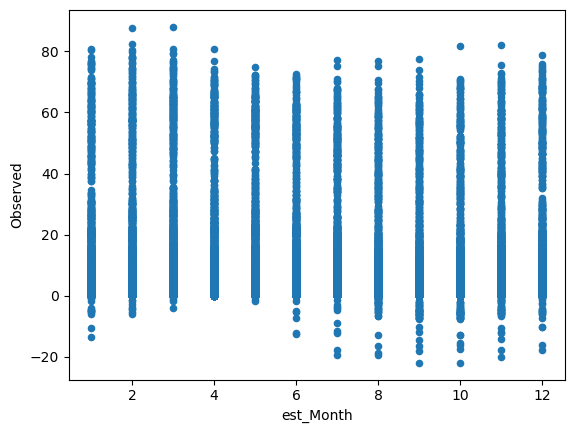

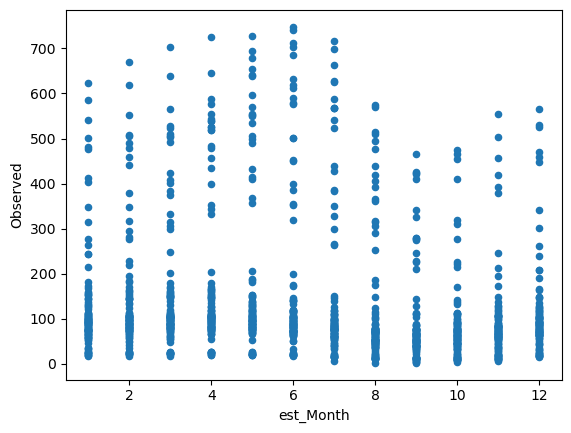

In [7]:
temp = waterData.groupby('Segment_id').agg('mean')
highSegments = temp[temp['Observed']>61].index
waterData.query('Segment_id not in @highSegments').plot(kind = 'scatter', x = 'est_Month', y = 'Observed')
waterData.query('Segment_id in @highSegments').plot(kind = 'scatter', x = 'est_Month', y = 'Observed')

<span style="color:purple">
    <font size="+2">
        Small analysis validating the yearly cyclic nature of Observed <br>
        Maybe see how the other 3 predecitng variables change over the year
    </font>
</style>

<AxesSubplot:xlabel='est_Month', ylabel='Evapotranspiration'>

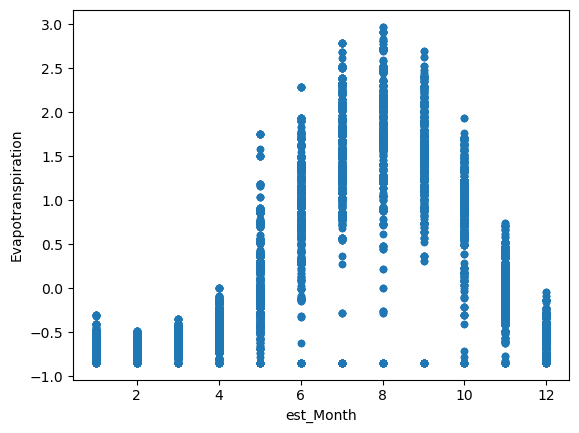

In [18]:
waterData.plot(kind = 'scatter', x = 'est_Month', y = 'Evapotranspiration')

<AxesSubplot:xlabel='est_Month', ylabel='Irrigation_pumping'>

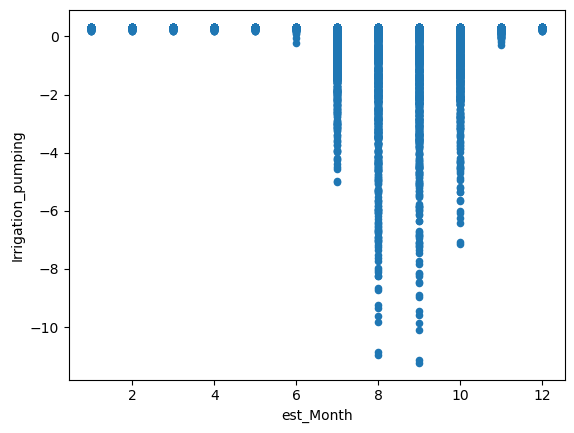

In [19]:
waterData.plot(kind = 'scatter', x = 'est_Month', y = 'Irrigation_pumping')

### A graphical representation of the flows across the river

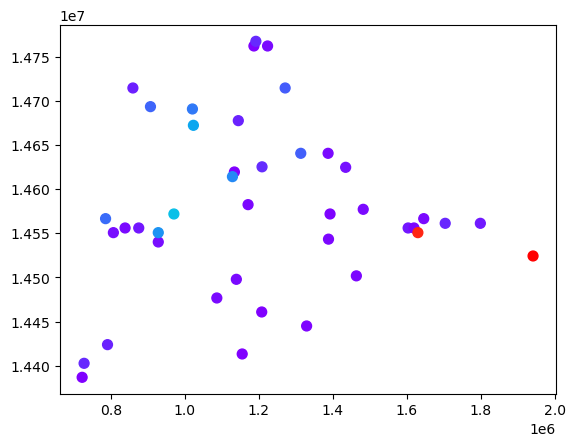

In [8]:
temp = waterData.groupby('Segment_id').agg('mean')
plt.scatter( x= temp.x, y = temp.y, s=50, c=temp.Observed, cmap='rainbow')

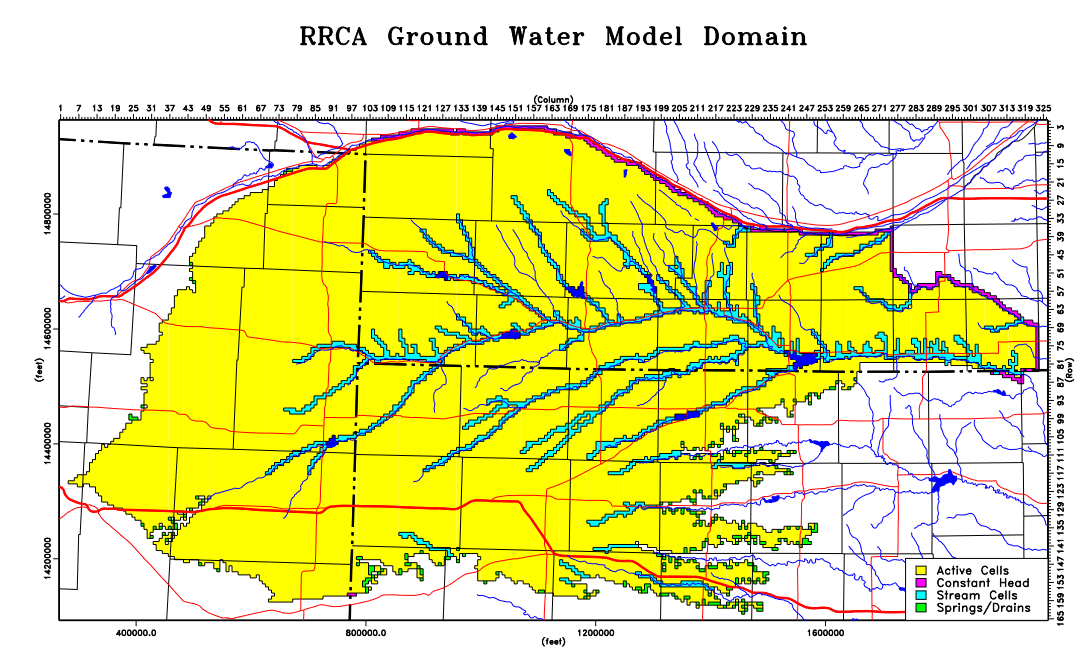

<span style="color:purple">
    <font size="+2">
        See how distance from source (the right most red dot) explains baseflow
    </font>
</style>

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,est_Month,distToSource
0,710732,144,1086190,14476800,-0.662247,0.387574,0.331399,0.145161,1.0,0.268913
1,710763,144,1086190,14476800,-0.542268,1.399663,0.331399,0.445161,2.0,0.268913
2,710791,144,1086190,14476800,-0.425447,1.399663,0.331399,1.332203,3.0,0.268913
3,710822,144,1086190,14476800,-0.283367,1.399663,0.331399,2.932203,4.0,0.268913
4,710852,144,1086190,14476800,1.749952,1.399663,0.331399,3.728689,5.0,0.268913
...,...,...,...,...,...,...,...,...,...,...
15586,721810,98,721870,14387040,-0.848529,-1.418777,0.331399,0.298500,5.0,1.538097
15587,721841,98,721870,14387040,-0.848529,-1.418777,0.331399,0.211475,6.0,1.538097
15588,721871,98,721870,14387040,-0.848529,-1.418777,0.331399,0.122951,7.0,1.538097
15589,721902,98,721870,14387040,-0.848529,-1.418777,0.331399,0.120000,8.0,1.538097


<AxesSubplot:xlabel='distToSource', ylabel='Observed'>

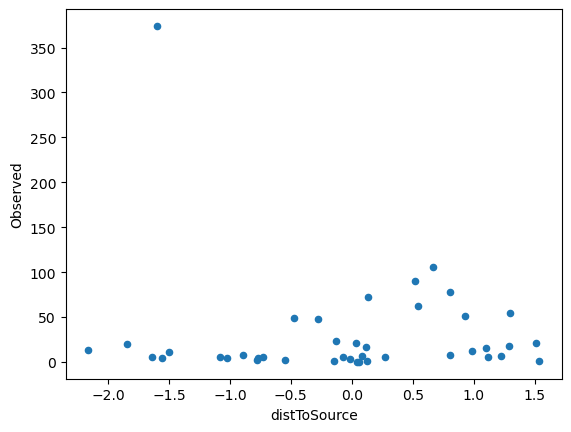

In [66]:
temp = waterData.groupby('Segment_id').agg('mean')
# Segment 256 has the highest average baseflow
topSeg = temp.nlargest(1,'Observed')
sourceX = topSeg.x.values
sourceY = topSeg.y.values
# print(sourceX.values)
waterData = waterData.assign(distToSource = lambda waterData: np.sqrt((sourceX-waterData.x)**2 + (sourceY-waterData.y)**2))

# And standardize it
waterData['distToSource'] = (waterData['distToSource'] - waterData['distToSource'].mean()) / waterData['distToSource'].std()
display(waterData)

#Ignore the source itself
temp = waterData.groupby('Segment_id').agg('mean')
temp = temp.drop(index = topSeg.index)
temp.plot(kind = 'scatter',x='distToSource',y='Observed')

## Start the analysis

In [9]:
def waterLinReg(data = waterData, x = 'Irrigation_pumping',y='Observed',segment = 0):
    intercepts = []
    coefs = []
    R2scores = []
    
    segList = []
    if segment ==0:
        segList = data.Segment_id.unique()
    else:
        segList = [segment]
        
    for segment in segList:
            for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
                lm = LinearRegression()

                subdata = data[data.Segment_id==segment]
                subdata = subdata[subdata.est_Month==float(month)]
                if subdata.size > 1:
                    featureCols = [x]
                    X = subdata[x]
                    y = subdata.Observed


                    lm.fit(X,y)
                    intercepts.append(lm.intercept_)
                    coefs.append(lm.coef_)
                    score = lm.score(X, y)
                    if not math.isnan(score): 
                        R2scores.append(lm.score(X,y))

    return intercepts, coefs, R2scores

<span style="color:purple">
    <font size="+2">
        Do something like the following for all combinations of our predictors.
    </font>
</style>

In [10]:
[testInter ,testCoefs, testR] = waterLinReg(x=['Evapotranspiration'])
print('Mean R^2 scores:',sum(testR)/len(testR),'Variance of R^2 scores:',variance(testR))
[testInter ,testCoefs, testR] = waterLinReg(x=['Irrigation_pumping'])
print('Mean R^2 scores:',sum(testR)/len(testR),'Variance of R^2 scores:',variance(testR))
[testInter ,testCoefs, testR] = waterLinReg(x=['Precipitation'])
print('Mean R^2 scores:',sum(testR)/len(testR),'Variance of R^2 scores:',variance(testR))

C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.11144158138527513 Variance of R^2 scores: 0.030674392411239284


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.08905001121612982 Variance of R^2 scores: 0.030605812772798453


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.18443977497425393 Variance of R^2 scores: 0.05385165534762955


In [11]:
columns = ["Evapotranspiration", "Irrigation_pumping", "Precipitation"]
for i in range(len(columns)):
    for j in range(i, len(columns)):
        if i != j:
            [testInter, testCoefs, testR] = waterLinReg(x=[columns[i], columns[j]])
            newTestR = []
            for k in range(len(testR)):
                if testR[k] > -10000.0:
                    newTestR.append(testR[k])
            testR = newTestR
            print('Mean R^2 scores:',sum(testR)/len(testR),'Variance of R^2 scores:',variance(testR))

[testInter, testCoefs, testR] = waterLinReg(x=[columns[0], columns[1], columns[2]])
newTestR = []
for i in range(len(testR)):
    if testR[i] > -10000.0:
        newTestR.append(testR[i])
testR = newTestR
print('Mean R^2 scores:',sum(testR)/len(testR),'Variance of R^2 scores:',variance(testR))


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.19918001727537465 Variance of R^2 scores: 0.059530924026898815


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.25088219083070595 Variance of R^2 scores: 0.07298565425376571


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.2547398960888229 Variance of R^2 scores: 0.06880579471125793


C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Jacob\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Mean R^2 scores: 0.3185728410142712 Variance of R^2 scores: 0.08558237780552322


<span style="color:purple">
    <font size="+2">
        Based on which set of predictors did best, plot a regression or two (ie. two different sections of the river) with our formula
    </font>
</style>

In [12]:
sns.regplot(x=columns, y="Observed", data=waterData)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 3 and the array at index 1 has size 15591